In [1]:
import pandas as pd

df = pd.read_csv("hf://datasets/GeorgiaCh96/WESAD_raw_data/WESAD_raw_data.csv")

C:\Users\User\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df.head()

,Time,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,...,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,subject id,condition,SSSQ
0,2.500754,654.010015,649.40833,49.342563,11.677158,11.676994,4.225563,92.266721,5.75,0.25,...,0.217992,9.605557,1.925085e+09,0.185010,0.246361,0.868076,0.367149,10,baseline,3
1,2.504921,654.063862,649.40833,49.300854,11.611629,11.611626,4.245817,92.258202,5.75,0.25,...,0.212375,9.605113,1.956097e+08,0.181651,0.242055,0.865946,0.377283,10,baseline,3
2,2.509087,654.024936,649.40833,49.326015,11.627159,11.627112,4.242310,92.264235,5.75,0.25,...,0.216107,9.605427,-4.897165e+06,0.178633,0.237930,0.865327,0.386985,10,baseline,3
3,2.513254,653.968183,649.40833,49.369481,11.417706,11.417571,4.323940,92.273203,5.50,0.25,...,0.222014,9.605894,-2.305165e+06,0.175917,0.234067,0.865965,0.396084,10,baseline,3
4,2.517421,654.048424,649.40833,49.279428,11.230305,11.228757,4.388076,92.259766,5.25,0.25,...,0.214546,9.605195,-2.205377e+06,0.172920,0.230420,0.867653,0.403953,10,baseline,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196978 entries, 0 to 196977
Data columns (total 66 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Time                      196978 non-null  float64
 1   MEAN_RR                   196978 non-null  float64
 2   MEDIAN_RR                 196978 non-null  float64
 3   SDRR                      196978 non-null  float64
 4   RMSSD                     196978 non-null  float64
 5   SDSD                      196978 non-null  float64
 6   SDRR_RMSSD                196978 non-null  float64
 7   HR                        196978 non-null  float64
 8   pNN25                     196978 non-null  float64
 9   pNN50                     196978 non-null  float64
 10  SD1                       196978 non-null  float64
 11  SD2                       196978 non-null  float64
 12  KURT                      196978 non-null  float64
 13  SKEW                      196978 non-null  f

In [5]:
df.describe()

,Time,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,...,SD1_BOXCOX,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,subject id,SSSQ
count,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,...,196978.000000,1.969780e+05,196978.000000,1.969780e+05,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000,196978.000000
mean,42.986362,804.740244,803.678155,76.634050,15.080419,15.077022,5.306693,78.419773,11.329957,1.287022,...,25.231274,1.233311e+00,8.808526,-2.862725e+06,0.158478,0.183163,10.990521,0.038401,9.355446,3.721994
std,28.714636,154.478995,160.066652,35.108739,6.253358,6.252735,1.694883,16.844526,10.802475,2.170988,...,73.114886,4.669007e+00,0.910848,9.628463e+08,0.185347,0.405912,23.801154,0.084816,4.543825,0.907817
min,1.683802,411.068840,411.966595,13.786706,2.294390,2.292144,1.887603,47.557070,0.000000,0.000000,...,0.645807,8.252542e-11,6.896163,-3.426834e+11,0.021295,0.008200,0.294702,0.000009,2.000000,1.000000
25%,16.871343,711.179980,704.989300,53.857813,10.108703,10.105987,4.171775,66.657458,2.250000,0.000000,...,1.912526,7.437414e-02,8.164402,-3.508506e+06,0.073721,0.043734,2.292763,0.003695,5.000000,3.000000
50%,39.567420,807.020950,805.161835,69.658364,14.504216,14.500798,5.104893,75.123647,8.250000,0.250000,...,4.575258,2.840353e-01,8.667390,-8.299300e+05,0.107864,0.080790,4.547541,0.011600,9.000000,4.000000
75%,65.408927,909.336258,910.768245,93.341563,18.815473,18.812301,6.016488,85.248805,17.250000,1.500000,...,14.295244,7.581712e-01,9.233028,3.275802e+06,0.172253,0.179996,9.491981,0.036999,13.000000,4.000000
max,115.498517,1341.611513,1297.565400,418.066612,34.881131,34.880732,22.194700,146.191044,46.750000,13.000000,...,479.384168,2.459810e+02,12.090949,1.092115e+11,4.771071,9.714187,537.538316,1.129262,17.000000,5.000000


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

array([[<Axes: title={'center': 'Time'}>,
        <Axes: title={'center': 'MEAN_RR'}>,
        <Axes: title={'center': 'MEDIAN_RR'}>,
        <Axes: title={'center': 'SDRR'}>,
        <Axes: title={'center': 'RMSSD'}>,
        <Axes: title={'center': 'SDSD'}>,
        <Axes: title={'center': 'SDRR_RMSSD'}>,
        <Axes: title={'center': 'HR'}>],
       [<Axes: title={'center': 'pNN25'}>,
        <Axes: title={'center': 'pNN50'}>,
        <Axes: title={'center': 'SD1'}>, <Axes: title={'center': 'SD2'}>,
        <Axes: title={'center': 'KURT'}>,
        <Axes: title={'center': 'SKEW'}>,
        <Axes: title={'center': 'MEAN_REL_RR'}>,
        <Axes: title={'center': 'MEDIAN_REL_RR'}>],
       [<Axes: title={'center': 'SDRR_REL_RR'}>,
        <Axes: title={'center': 'RMSSD_REL_RR'}>,
        <Axes: title={'center': 'SDSD_REL_RR'}>,
        <Axes: title={'center': 'SDRR_RMSSD_REL_RR'}>,
        <Axes: title={'center': 'KURT_REL_RR'}>,
        <Axes: title={'center': 'SKEW_REL_RR'}>,
    

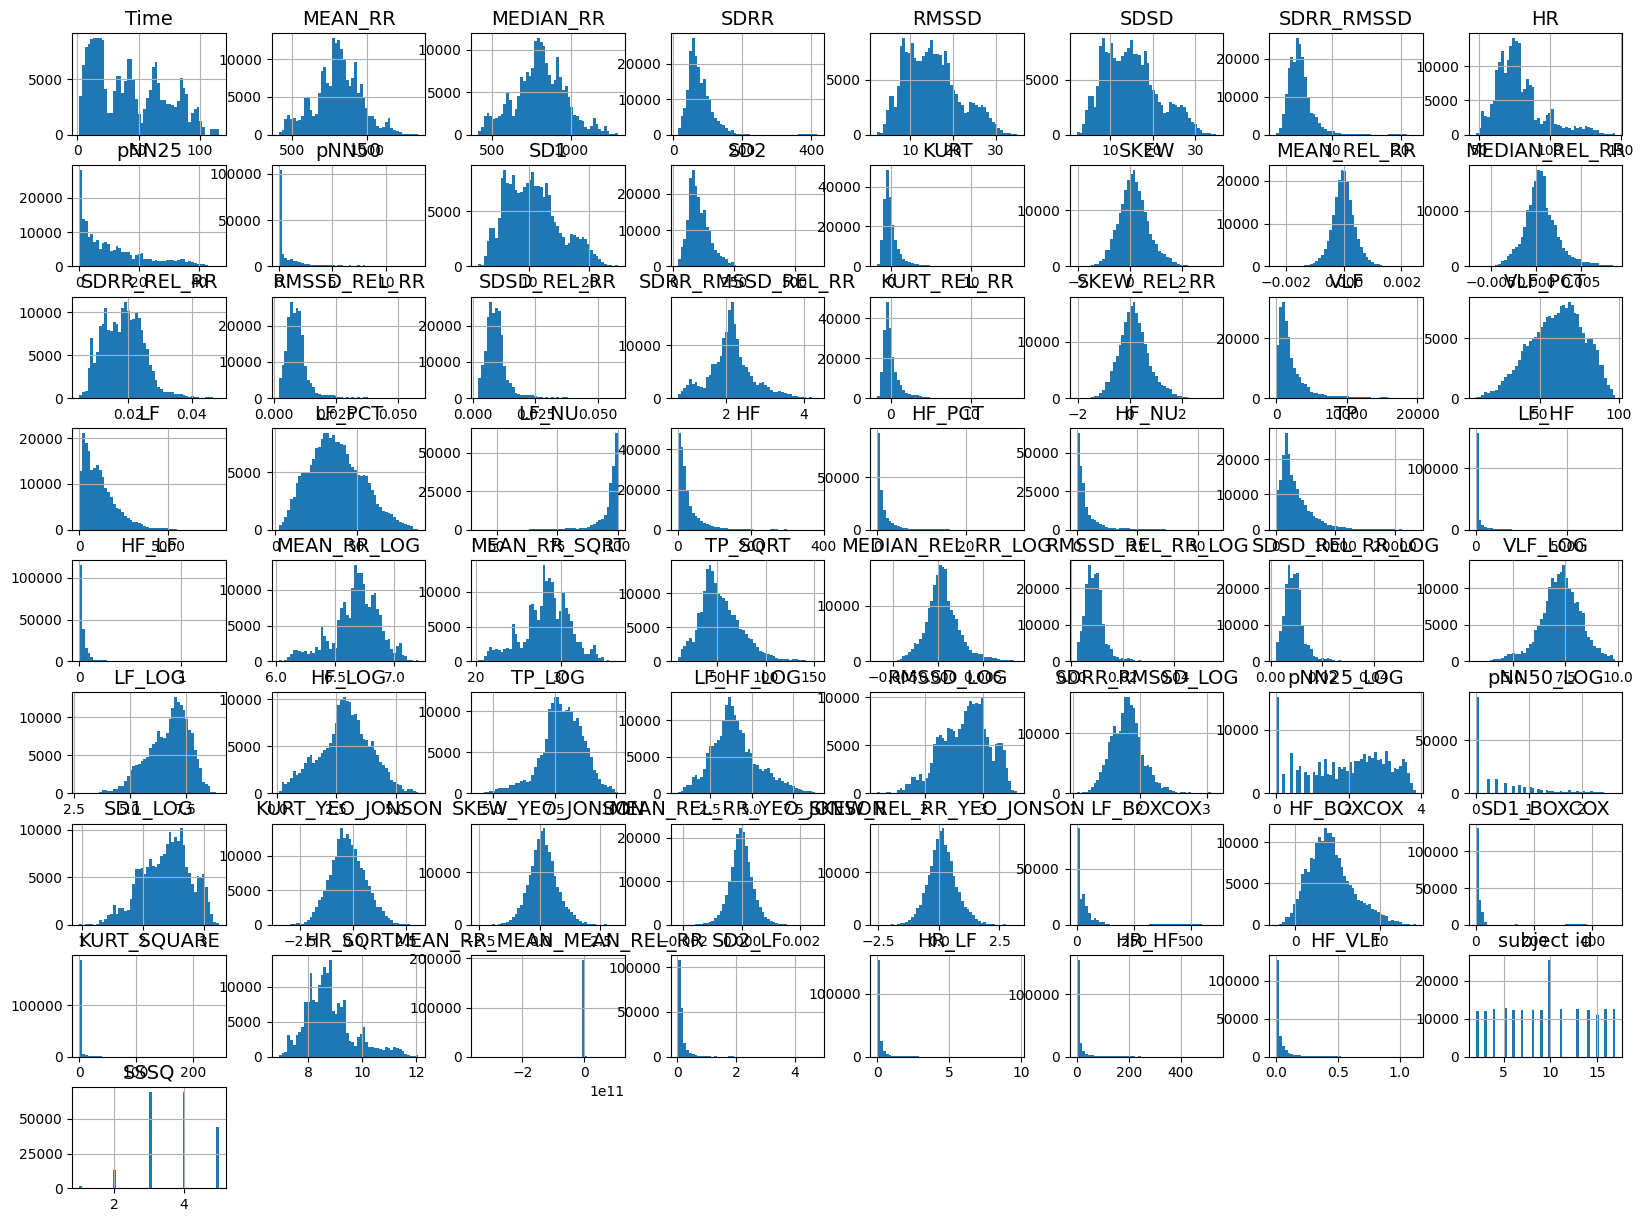

In [9]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df.hist(bins=50 , figsize=(20,15))

In [10]:
from zlib import crc32

def is_id_in_test_set(identifier,ratio):
    return crc32(np.int64(identifier)) < ratio*2**32

def split_train_test_by_id(data, ratio, column_id):
    ids=data[column_id]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_,ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
df_with_id = df.reset_index() #adds indexes as a column
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")

In [13]:
test_set.head()

,index,Time,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,...,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,subject id,condition,SSSQ
2,2,2.509087,654.024936,649.40833,49.326015,11.627159,11.627112,4.242310,92.264235,5.75,...,0.216107,9.605427,-4.897165e+06,0.178633,0.237930,0.865327,0.386985,10,baseline,3
5,5,2.521587,654.289487,649.40833,48.956975,11.280169,11.277893,4.340092,92.217740,5.25,...,0.222048,9.603007,-2.849473e+06,0.169215,0.226899,0.870280,0.410460,10,baseline,3
12,12,2.550754,653.892797,649.40833,49.618286,11.694544,11.693857,4.242858,92.290535,5.75,...,0.197806,9.606796,2.971589e+06,0.160525,0.212612,0.920531,0.439088,10,baseline,3
16,16,2.567421,653.292373,649.40833,50.307265,11.693170,11.691872,4.302278,92.392082,5.75,...,0.239080,9.612080,2.100608e+06,0.161993,0.211809,0.967694,0.424121,10,baseline,3
23,23,2.596587,651.964359,647.56340,51.124659,11.639054,11.637744,4.392510,92.599323,5.75,...,0.331084,9.622854,3.457633e+06,0.173401,0.223539,1.066551,0.291751,10,baseline,3


In [14]:
df_with_id.isnull().sum()

index         0
Time          0
MEAN_RR       0
MEDIAN_RR     0
SDRR          0
             ..
HR_HF         0
HF_VLF        0
subject id    0
condition     0
SSSQ          0
Length: 67, dtype: int64

In [ ]:
df['condition'].describe()



array(['baseline', 'amusement', 'meditation', 'stress'], dtype=object)

In [18]:
df['condition'].unique()

array(['baseline', 'amusement', 'meditation', 'stress'], dtype=object)